# Task 7

We ran out of time!
Sorry for the unordered data. 
We use the algorithms from the 6th problem
# Sorry :)

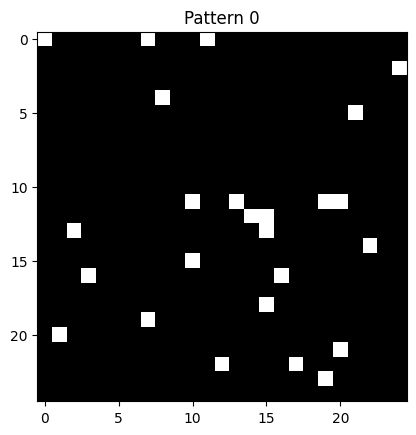

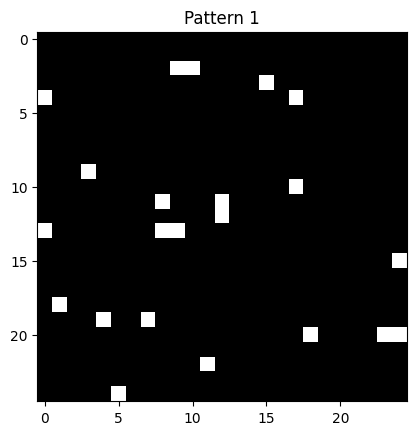

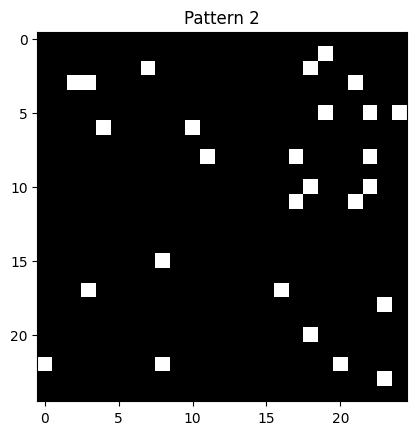

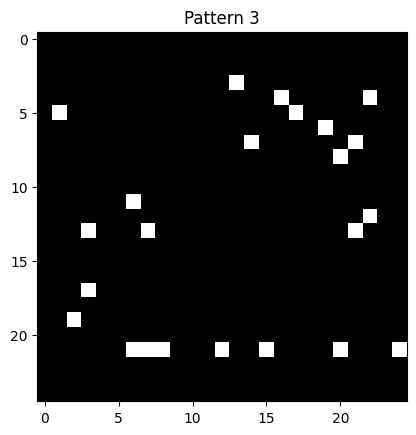

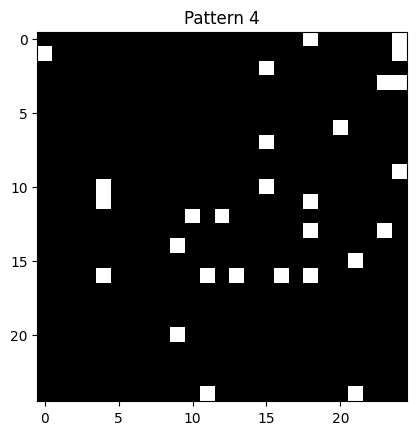

Average pattern’s total pixel value: -7.73070496506989e-16


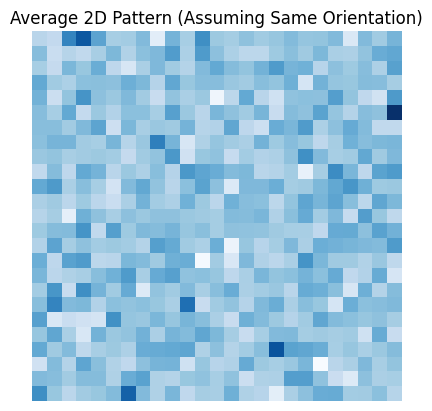

Run 0: Distortia score = 622.394294150375
Run 1: Distortia score = 622.2950708917749
Run 2: Distortia score = 622.435725402695
Best Distortia score: 622.2950708917749
Cluster 0 corresponds to 0° Rotation
Cluster 1 corresponds to 180° Rotation
Cluster 2 corresponds to 270° Rotation
Cluster 3 corresponds to 90° Rotation
0° Rotation: 40281 elements
90° Rotation: 9981 elements
180° Rotation: 39606 elements
270° Rotation: 10132 elements


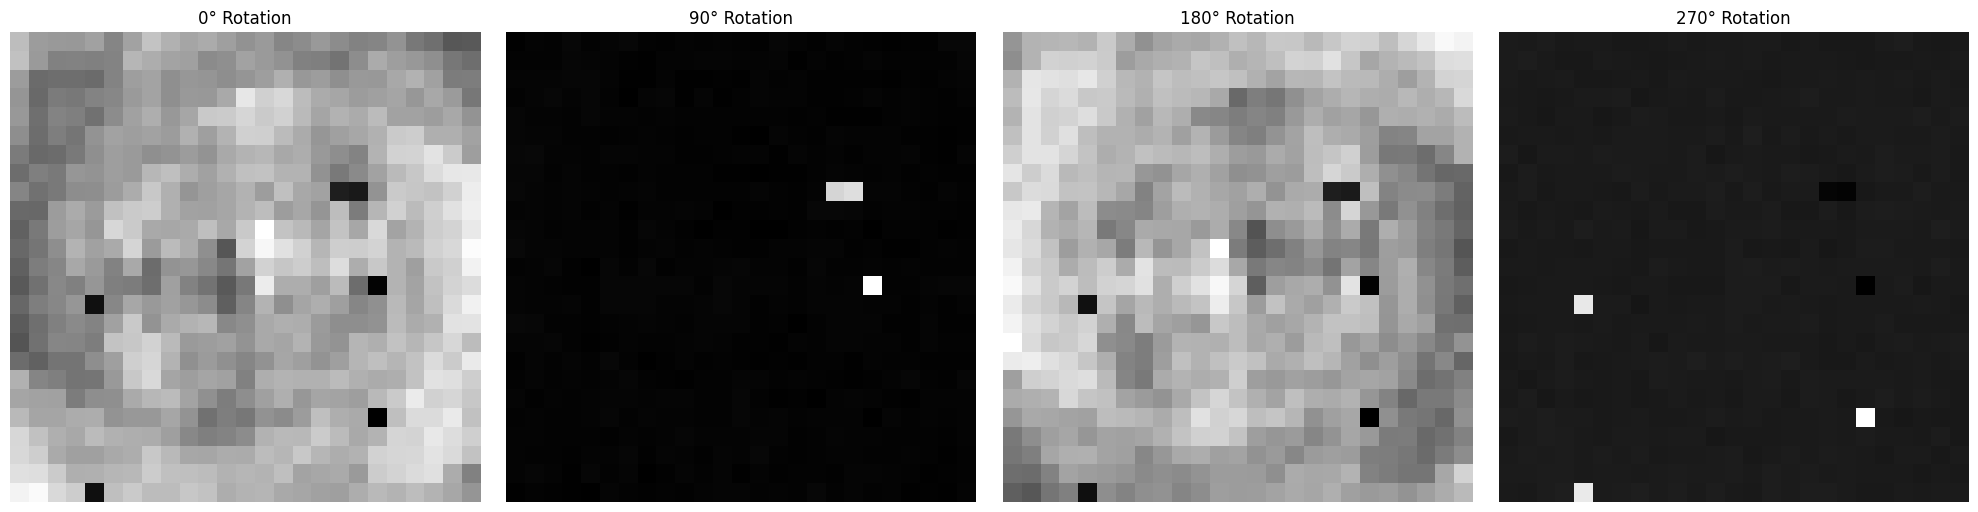

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Load the data
loaded = np.load('endeavour.npz')
task7a = loaded["task7a"]
task7b = loaded["task7b"]

# Create a design matrix from the sparse format
num_patterns = 100000
pattern_size = 25 * 25  # 625
design_matrix = np.zeros((num_patterns, pattern_size))

for row, col in zip(task7a, task7b):
    design_matrix[row, col] = 1

# Inspect data sparsity
for i in range(5):
    pattern = design_matrix[i].reshape(25, 25)
    plt.imshow(pattern, cmap='gray')
    plt.title(f"Pattern {i}")
    plt.show()

# Normalize the data
scaler = StandardScaler()
design_matrix_normalized = scaler.fit_transform(design_matrix)

# Part (a): Compute the average pattern’s total pixel value
average_pixel_value = np.mean(np.sum(design_matrix_normalized, axis=1))
print("Average pattern’s total pixel value:", average_pixel_value)

# Part (b): Render the average 2D pattern assuming all patterns have the same orientation
average_pattern = np.mean(design_matrix_normalized, axis=0)
average_pattern_2d = average_pattern.reshape(25, 25)

plt.imshow(average_pattern_2d, cmap='Blues')
plt.title("Average 2D Pattern (Assuming Same Orientation)")
plt.axis('off')
plt.show()

# Run KMeans multiple times and choose the one with minimal distortia score
best_kmeans = None
best_labels = None
best_distortia = float('inf')

n_runs = 3  # Number of times to run KMeans

for run in range(n_runs):
    kmeans = KMeans(n_clusters=4, init='k-means++', random_state=run).fit(design_matrix_normalized)
    labels = kmeans.labels_
    
    # Calculate distortia score
    distortia = 0
    for i in range(4):  # Number of clusters
        cluster_points = design_matrix_normalized[labels == i]
        centroid = kmeans.cluster_centers_[i].reshape(1, -1)
        distortia += np.sum(np.square(cluster_points - centroid))
    
    print(f"Run {run}: Distortia score = {distortia/num_patterns}")
    
    # Update best result if current run has a lower distortia score
    if distortia < best_distortia:
        best_kmeans = kmeans
        best_labels = labels
        best_distortia = distortia

print("Best Distortia score:", best_distortia/num_patterns)

# Step 2: Gather and average the rows of the design matrix according to orientation classes
orientation_averages = []

for i in range(4):
    class_patterns = design_matrix_normalized[best_labels == i]
    average_class_pattern = np.mean(class_patterns, axis=0)
    orientation_averages.append(average_class_pattern)

# Determine rotation for each cluster
def determine_rotation(orientation_averages, reference_pattern):
    rotations = [reference_pattern,
                 np.rot90(reference_pattern, k=1),
                 np.rot90(reference_pattern, k=2),
                 np.rot90(reference_pattern, k=3)]
    rotation_errors = []

    for i, avg in enumerate(orientation_averages):
        avg_2d = avg.reshape(25, 25)
        for j, rot in enumerate(rotations):
            dist = np.sum((avg_2d - rot) ** 2)
            rotation_errors.append((i, j, dist))

    rotation_errors = sorted(rotation_errors, key=lambda x: x[2])

    used_rotations = set()
    resolved_order = [-1] * 4

    for i, j, dist in rotation_errors:
        if resolved_order[i] == -1 and j not in used_rotations:
            resolved_order[i] = j
            used_rotations.add(j)

    if len(set(resolved_order)) != 4:
        raise ValueError("Rotation determination failed. Please re-run or adjust the algorithm.")

    return resolved_order

rotation_order = determine_rotation(orientation_averages, design_matrix_normalized[0].reshape(25, 25))

# Print which cluster corresponds to which rotation
rotation_titles = ["0° Rotation", "90° Rotation", "180° Rotation", "270° Rotation"]
for i, rotation in enumerate(rotation_order):
    print(f"Cluster {i} corresponds to {rotation_titles[rotation]}")

# Print the number of elements in each cluster with rotation, sorted by rotation order
cluster_counts = np.bincount(best_labels)
rotation_to_cluster = {rotation_order[i]: i for i in range(4)}
sorted_rotations = sorted(rotation_to_cluster.items())

for rotation, cluster_num in sorted_rotations:
    print(f"{rotation_titles[rotation]}: {cluster_counts[cluster_num]} elements")

# Reorder the clusters based on the determined rotation
reordered_averages = [orientation_averages[rotation_order.index(i)] for i in range(4)]

# Render the 2D images for each orientation class
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    class_pattern_2d = reordered_averages[i].reshape(25, 25)
    ax.imshow(class_pattern_2d, cmap='gray')
    ax.set_title(rotation_titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


# Understading the data

# Building a model